In [67]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List

In [68]:
def f(x=0.0, t=0.0):
    """Функция источника"""
    return 0

def fi(x=0.0):
    """Функция начальных условий"""
    return np.cos(2 * np.pi * x)

def psi(x=0.0):
    """Функция начальной скорости"""
    return 0

def m1(t=0.0):
    """Граничное условие при x=0"""
    return np.cos(2 * np.pi * t)

def m2(t=0.0):
    """Граничное условие при x=L"""
    return np.cos(2 * np.pi) * np.cos(2 * np.pi * t)

def analytical_solution(x: float, t: float) -> float:
    """Аналитическое решение"""
    return np.cos(2 * np.pi * x) * np.cos(2 * np.pi * t)

In [69]:
def tridiagonal_matrix_algorithm(N: int,
                     A: List[float],
                     B: List[float],
                     C: List[float],
                     F: List[float],
                     hi: List[float],
                     mu: List[float]) -> List[float]:

    a = np.zeros(N + 1)
    b = np.zeros(N + 1)
    y = np.zeros(N + 1)

    a[1] = hi[1]
    b[1] = mu[1]

    for i in range(1, N):
        d = C[i] - A[i] * a[i]
        a[i + 1] = B[i] / d
        b[i + 1] = (F[i] + A[i] * b[i]) / d

    y[N] = (mu[2] + hi[2] * b[N]) / (1 - hi[2] * a[N])

    for i in range(N - 1, -1, -1):
        y[i] = a[i + 1] * y[i + 1] + b[i + 1]

    return y

In [70]:
def oscillation(Tmax, h, tau, sig, f, m1, m2, fi, psi):
    N = int(1 / h)
    T = int(Tmax / tau)
    v = h**2 / tau**2

    x = [i * h for i in range(0, N + 1)]
    t = [n * tau for n in range(0, T + 1)]

    f = [[0] + [f(x[i], t[n]) for i in range(1, N)] for n in range(0, T + 1)]

    m1 = [m1(t[n]) for n in range(0, T + 1)]
    m2 = [m2(t[n]) for n in range(0, T + 1)]

    fi = [fi(x[i]) for i in range(0, N + 1)]
    psi = [psi(x[i]) for i in range(0, N + 1)]

    A = [0] + [sig for i in range(1, N)]
    B = [0] + [sig for i in range(1, N)]
    C = [sum(x, v) for x in zip(A, B)]

    y = [fi, [m1[1]] + [fi[i] + tau * psi[i] + 0.5*tau*tau*((fi[i + 1] - 2*fi[i] + fi[i - 1]) / (h**2) + f[0][i]) for i in range(1, N)] + [m2[1]]]

    for n in range(1, T):
        Fn = [0] + [-2*(1 - 2 * sig - v) * y[n][i] - (2 * sig + v) * y[n-1][i] + (1 - 2 * sig) * (y[n][i + 1] + y[n][i - 1]) + sig * (y[n - 1][i + 1] + y[n - 1][i - 1]) + h * h * f[n][i] for i in range(1, N)]
        y.append(tridiagonal_matrix_algorithm(N, A, B, C, Fn, [0]*3, [0, m1[n+1], m2[n+1]]))

    return y

def draw(Tmax: float, h: float, tau: float, sig: float,
                         f: Callable[[float, float], float],
                         m1: Callable[[float], float],
                         m2: Callable[[float], float],
                         fi: Callable[[float], float],
                         psi: Callable[[float], float],
                         u: Callable[[float, float], float]) -> None:

    N = int(1 / h)
    T = int(Tmax / tau)

    x = [i * h for i in range(0, N + 1)]
    t = [n * tau for n in range(0, T + 1)]

    y = oscillation(Tmax=Tmax, h=h, tau=tau, sig=sig, f=f, m1=m1, m2=m2, fi=fi, psi=psi)

    overall_max_error = 0

    for n in range(T + 1):
        u_values_n = [u(x[i], t[n]) for i in range(N + 1)]
        max_error_n = max(abs(np.array(y[n]) - np.array(u_values_n)))
        overall_max_error = max(overall_max_error, max_error_n)

    print(f"Погрешность = {overall_max_error:.4f}")

    time_steps = [0, T // 8, 2 * T // 3, T]

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    for idx, n in enumerate(time_steps):
        axs[idx].plot(x, y[n], label='Численное решение', color='blue', linestyle='-')
        axs[idx].plot(x, [u(x[i], t[n]) for i in range(N + 1)], label='Аналитическое решение', color='red')

        axs[idx].set_title(f"t = {n * tau:.2f}")
        axs[idx].set_xlabel("x")
        axs[idx].set_ylabel("y")
        axs[idx].set_ylim(-1.5, 1.5)
        axs[idx].set_xlim(0, x[-1])
        axs[idx].legend()
        axs[idx].grid()

    plt.tight_layout()
    plt.show()

Tmax = 3
h = 0.01

# Устойчивость

Устойчивость разностной схемы означает, что малые изменения или возмущения в начальных данных или в правой части уравнения приводят к незначительным изменениям в решении.

 # Абсолютно устойчивая схема

График представляет собой плавную косинусоиду без значительных искажений. Решение близко к аналитическому решению.

Ошибка остается на низком уровне и постепенно уменьшается при уменьшении шагов τ.

Погрешность = 0.0022


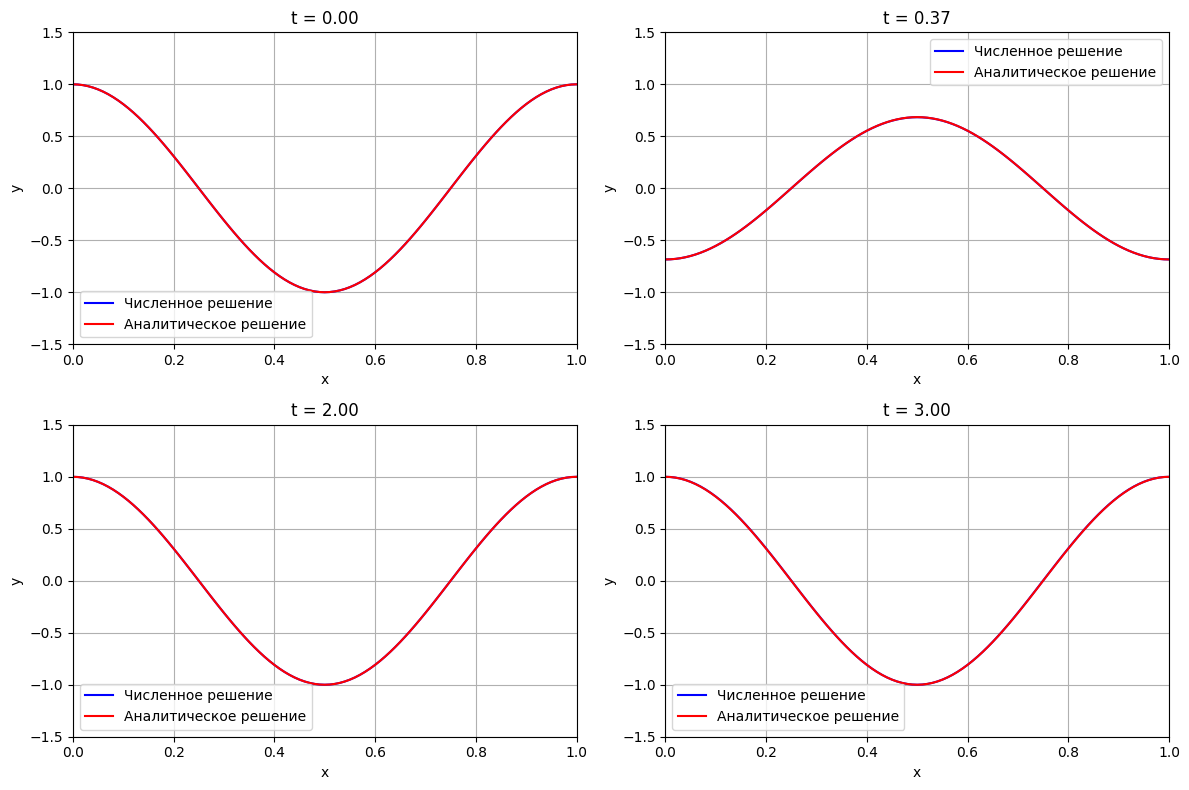

In [71]:
sig = 0.3
tau = 0.01

draw(Tmax=Tmax, h=h, tau=tau, sig=sig, f=f, m1=m1, m2=m2, fi=fi, psi=psi, u=analytical_solution)

Погрешность = 0.0006


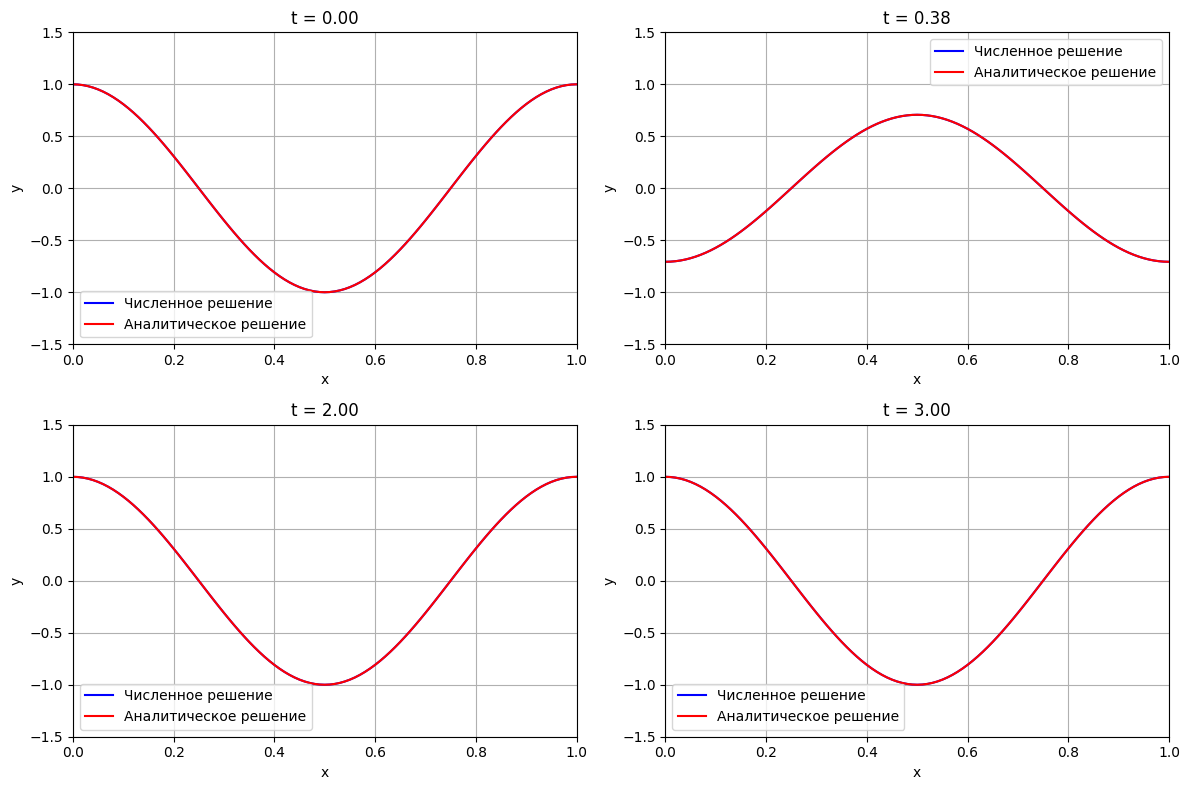

In [72]:
sig = 0.3
tau = 0.001

draw(Tmax=Tmax, h=h, tau=tau, sig=sig, f=f, m1=m1, m2=m2, fi=fi, psi=psi, u=analytical_solution)

Погрешность = 0.0006


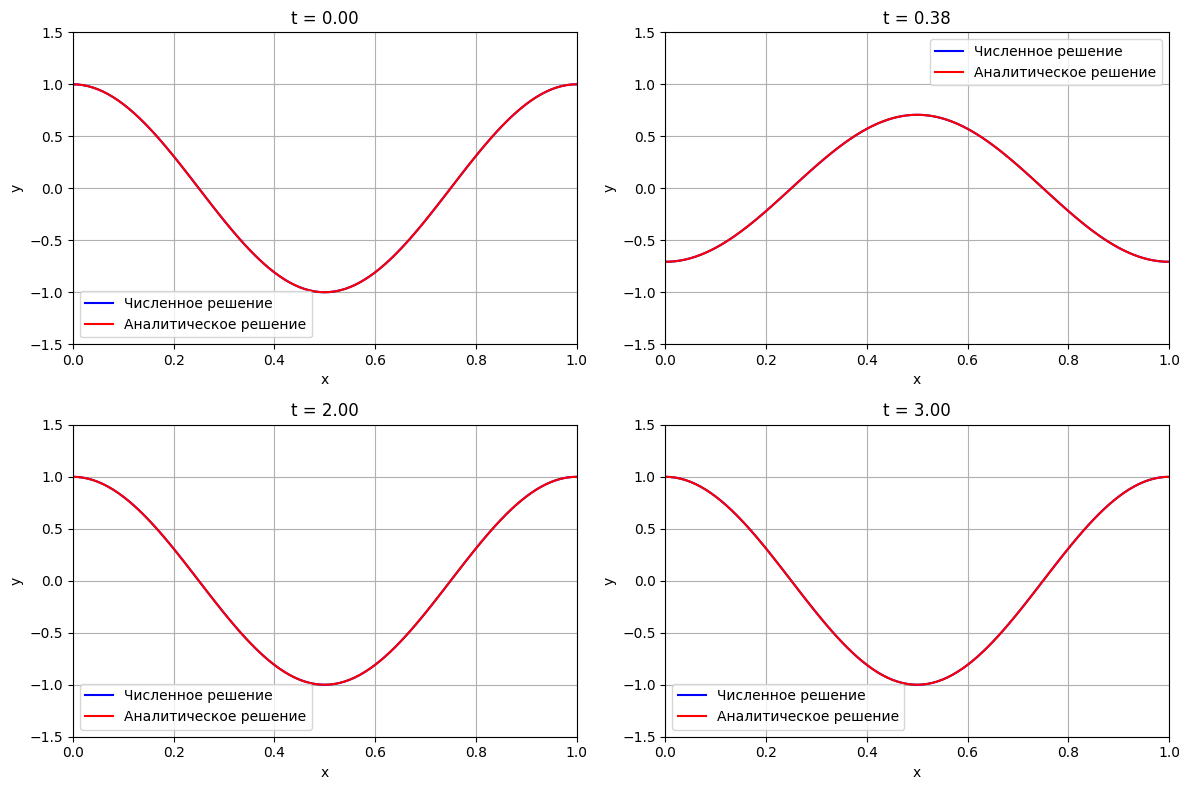

In [73]:
sig = 0.3
tau = 0.0001

draw(Tmax=Tmax, h=h, tau=tau, sig=sig, f=f, m1=m1, m2=m2, fi=fi, psi=psi, u=analytical_solution)

# Условно устойчивая схема

График также является косинусоидальным, но есть небольшие (или большие) искажения.

При невыполнении соотношения между h и τ график демонстрирует значительные искажения, "шумы" и расходимость. Ошибка стремится к бесконечности и резко возрастает, что указывает на то, что схема не может обеспечить стабильное решение.

Погрешность = 799291995.5807


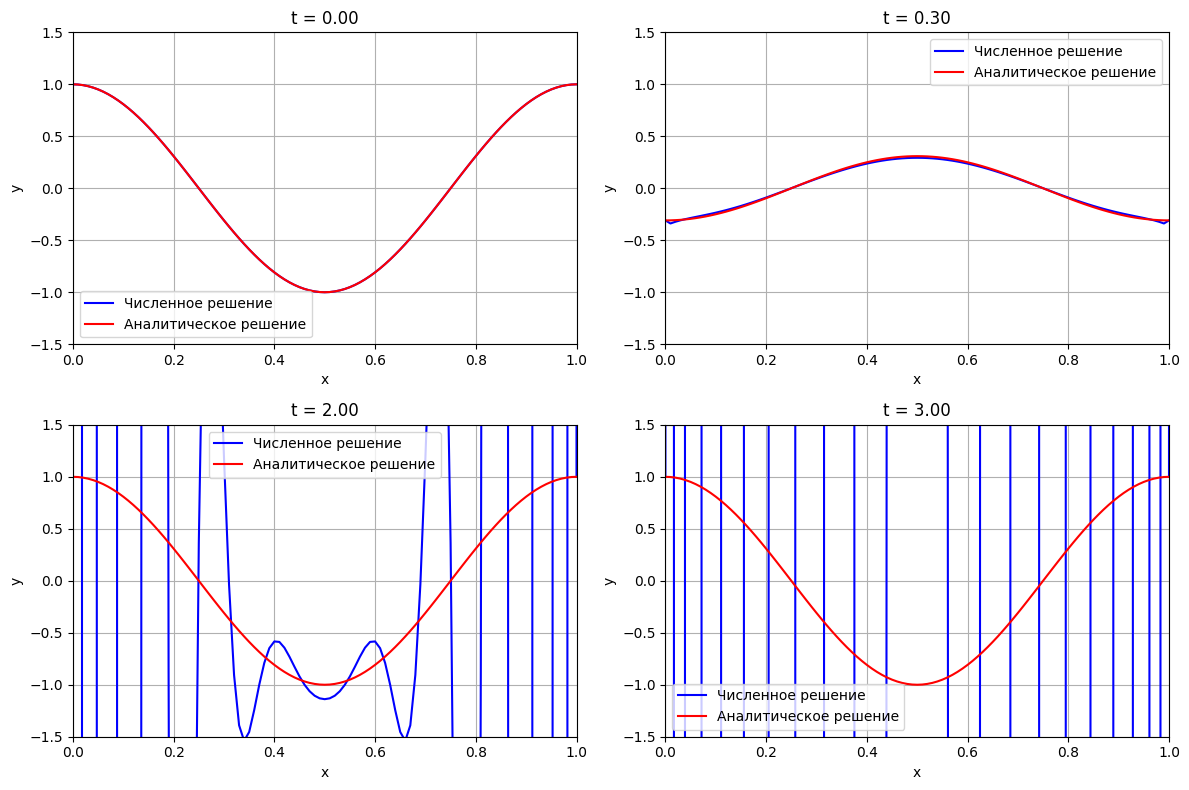

In [74]:
sig = 0.2
tau = 0.1

draw(Tmax=Tmax, h=h, tau=tau, sig=sig, f=f, m1=m1, m2=m2, fi=fi, psi=psi, u=analytical_solution)

Погрешность = 0.3304


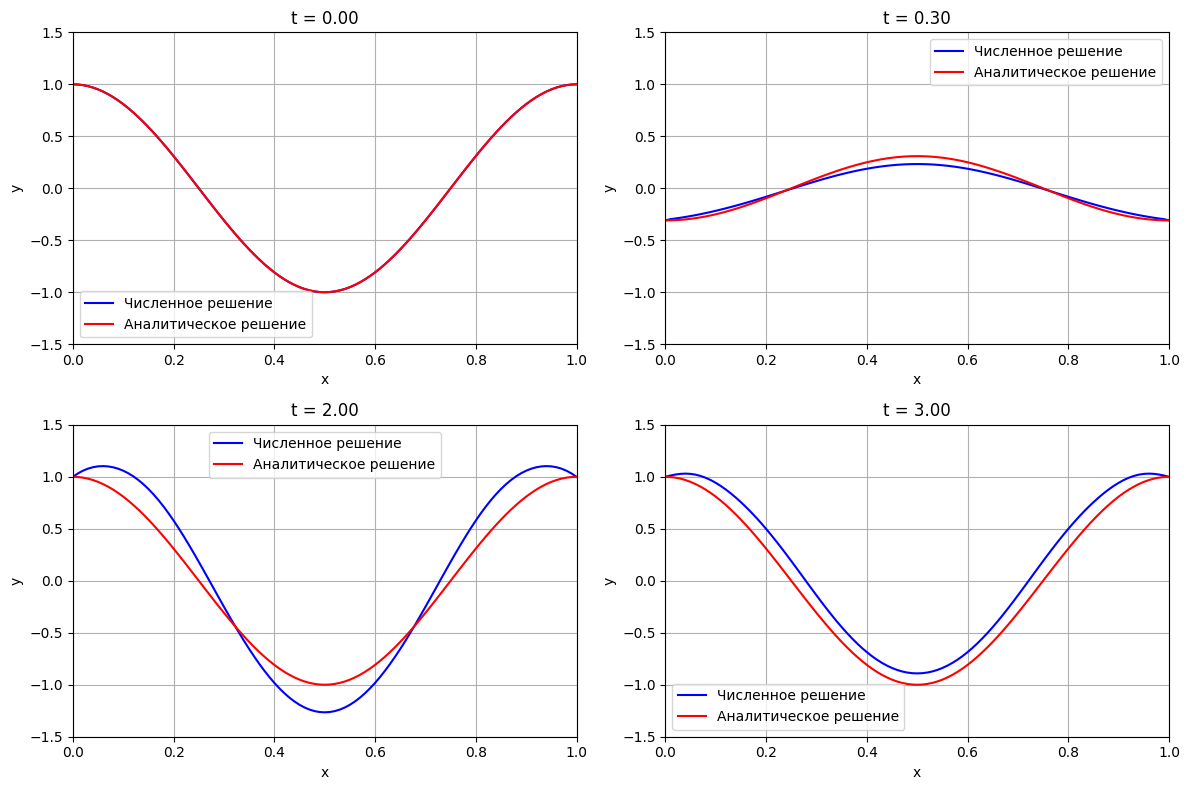

In [75]:
sig = 0.5
tau = 0.1

draw(Tmax=Tmax, h=h, tau=tau, sig=sig, f=f, m1=m1, m2=m2, fi=fi, psi=psi, u=analytical_solution)